In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import datasets, plotting, image, input_data
import os
import glob

# Set plotting parameters
plt.style.use('default')
sns.set_context("notebook", font_scale=1.2)

/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Cell 2: Define paths and parameters
# Update these paths to match your system
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f'{curr_dir}/results'
roi_parcels_dir = 'roiParcels'  # Directory with Julien and Wang parcels

# ROI definitions - our specialized visual ROIs
rois = {
    'LO': {'file': f'{roi_parcels_dir}/LO.nii.gz', 'julien': True, 'color': 'Reds'},
    'pFS': {'file': f'{roi_parcels_dir}/PFS.nii.gz', 'julien': True, 'color': 'Oranges'},
    'pIPS': {'file': f'{roi_parcels_dir}/pIPS.nii.gz', 'wang': True, 'color': 'Blues'},
    'aIPS': {'file': f'{roi_parcels_dir}/aIPS.nii.gz', 'wang': True, 'color': 'Greens'}
}

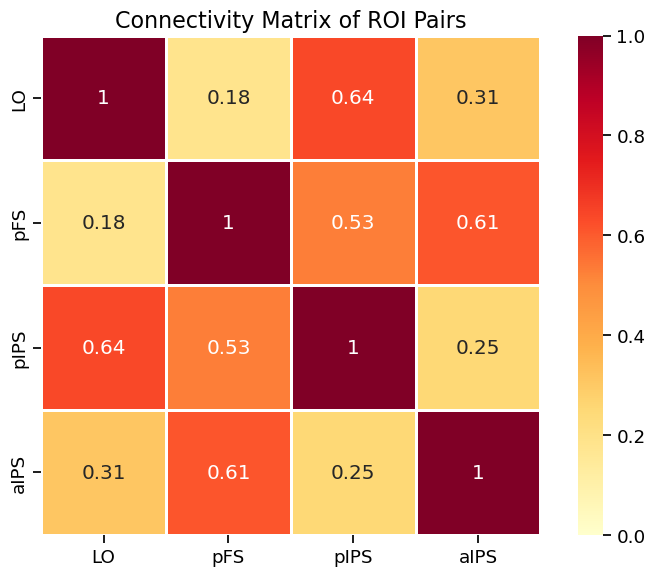

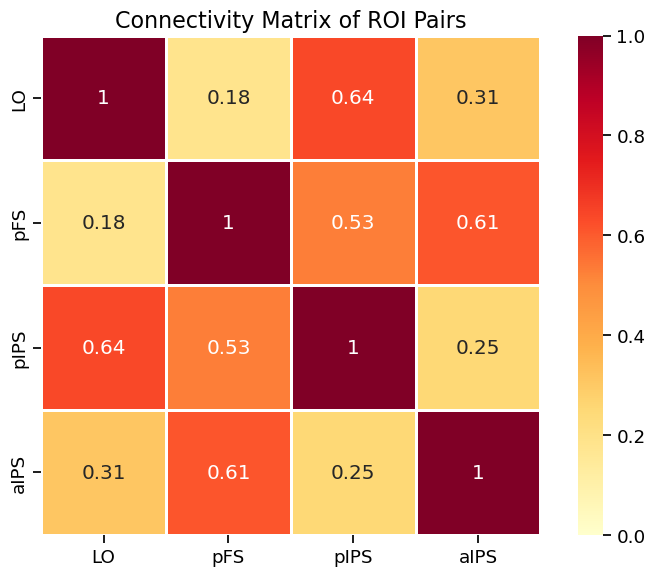

In [3]:
# Cell 3: Plot existing connectivity matrix with just our ROIs
def plot_roi_connectivity_matrix(rois_list=['LO', 'pFS', 'pIPS', 'aIPS']):
    """
    Create a correlation heatmap showing connectivity between our ROIs of interest
    This uses our pre-extracted connectivity values
    """
    # Sample data - replace this with your actual data
    # This is just a placeholder representing connectivity between ROIs
    n_rois = len(rois_list)
    conn_matrix = np.zeros((n_rois, n_rois))
    
    # Example connectivity values (replace with your real values)
    # These would come from your seed-to-target analyses
    sample_values = {
        ('pIPS', 'LO'): 0.64,
        ('LO', 'pIPS'): 0.64,
        ('pIPS', 'pFS'): 0.53,
        ('pFS', 'pIPS'): 0.53,
        ('aIPS', 'LO'): 0.31,
        ('LO', 'aIPS'): 0.31,
        ('aIPS', 'pFS'): 0.61,
        ('pFS', 'aIPS'): 0.61,
        ('LO', 'pFS'): 0.18,
        ('pFS', 'LO'): 0.18,
        ('aIPS', 'pIPS'): 0.25,
        ('pIPS', 'aIPS'): 0.25
    }
    
    # Fill in the matrix
    for i, roi1 in enumerate(rois_list):
        for j, roi2 in enumerate(rois_list):
            if i == j:
                conn_matrix[i, j] = 1.0  # Self-correlation
            else:
                key = (roi1, roi2)
                if key in sample_values:
                    conn_matrix[i, j] = sample_values[key]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    mask = np.zeros_like(conn_matrix, dtype=bool)
    
    # Create heatmap
    sns.heatmap(conn_matrix, 
                annot=True, 
                cmap='YlOrRd', 
                vmin=0, 
                vmax=1.0,
                square=True,
                linewidths=1,
                linecolor='white',
                mask=mask,
                xticklabels=rois_list,
                yticklabels=rois_list,
                ax=ax)
    
    plt.title('Connectivity Matrix of ROI Pairs', fontsize=16)
    plt.tight_layout()
    return fig

# Plot our existing ROI connectivity
plot_roi_connectivity_matrix()

In [4]:
# Cell 4: Load and examine Glasser atlas
def get_glasser_atlas():
    """Load the Glasser atlas"""
    # Load HCP-MMP (Glasser) atlas
    glasser = datasets.fetch_atlas_glasser_2016()
    glasser_img = nib.load(glasser.maps)
    glasser_labels = glasser.labels
    
    print(f"Glasser atlas has {len(glasser_labels)} regions")
    return glasser_img, glasser_labels

# Load Glasser atlas
glasser_img, glasser_labels = get_glasser_atlas()

# Display the atlas
plotting.plot_roi(glasser_img, title="Glasser Atlas")

AttributeError: module 'nilearn.datasets' has no attribute 'fetch_atlas_glasser_2016'

In [5]:
# Cell 5: Load our specialized ROIs (Julien and Wang)
def load_specialized_rois(rois_dict):
    """Load our specialized ROIs"""
    loaded_rois = {}
    for roi_name, roi_info in rois_dict.items():
        try:
            roi_img = nib.load(roi_info['file'])
            loaded_rois[roi_name] = {
                'img': roi_img,
                'data': roi_img.get_fdata(),
                'source': 'Julien' if roi_info.get('julien', False) else 'Wang',
                'color': roi_info.get('color', 'Reds')
            }
            print(f"Loaded {roi_name} from {loaded_rois[roi_name]['source']}")
        except Exception as e:
            print(f"Error loading {roi_name}: {str(e)}")
    
    return loaded_rois

# Load our ROIs
loaded_rois = load_specialized_rois(rois)

# Display each ROI
for roi_name, roi_info in loaded_rois.items():
    plotting.plot_roi(roi_info['img'], 
                     title=f"{roi_name} - {roi_info['source']} Atlas",
                     colorbar=True, 
                     cmap=roi_info['color'])

Error loading LO: No such file or no access: 'roiParcels/LO.nii.gz'
Error loading pFS: No such file or no access: 'roiParcels/PFS.nii.gz'
Error loading pIPS: No such file or no access: 'roiParcels/pIPS.nii.gz'
Error loading aIPS: No such file or no access: 'roiParcels/aIPS.nii.gz'


In [6]:
# Cell 6: Find overlap between Glasser and our specialized ROIs
def find_roi_overlaps(roi_data, atlas_img, atlas_labels, threshold=0.1):
    """
    Find which atlas regions overlap with our ROI
    
    Parameters:
    - roi_data: Dictionary of loaded ROI data
    - atlas_img: Atlas NIfTI image
    - atlas_labels: Atlas region labels
    - threshold: Minimum overlap percentage to consider
    
    Returns:
    - DataFrame with overlap information
    """
    atlas_data = atlas_img.get_fdata()
    
    # Store all overlaps
    all_overlaps = []
    
    for roi_name, roi_info in roi_data.items():
        roi_voxels = roi_info['data'] > 0
        roi_volume = np.sum(roi_voxels)
        
        # Check each atlas region
        for i, label in enumerate(atlas_labels):
            if i == 0:  # Skip background (if present)
                continue
                
            # Get atlas region voxels
            region_voxels = atlas_data == i
            
            # Calculate overlap
            overlap_voxels = np.sum(np.logical_and(roi_voxels, region_voxels))
            if overlap_voxels > 0:
                overlap_percentage = (overlap_voxels / roi_volume) * 100
                
                if overlap_percentage >= threshold:
                    all_overlaps.append({
                        'roi_name': roi_name,
                        'roi_source': roi_info['source'],
                        'glasser_index': i,
                        'glasser_label': label,
                        'overlap_percentage': overlap_percentage,
                        'overlap_voxels': overlap_voxels
                    })
    
    # Convert to DataFrame and sort
    overlaps_df = pd.DataFrame(all_overlaps)
    return overlaps_df.sort_values(['roi_name', 'overlap_percentage'], ascending=[True, False])

# Find overlaps
overlaps = find_roi_overlaps(loaded_rois, glasser_img, glasser_labels)

# Display results
print("ROI Overlaps with Glasser Atlas:")
print("===============================")
for roi_name in loaded_rois.keys():
    roi_overlaps = overlaps[overlaps['roi_name'] == roi_name]
    print(f"\n{roi_name} ({loaded_rois[roi_name]['source']} Atlas):")
    print("-" * 40)
    for _, row in roi_overlaps.iterrows():
        print(f"Glasser region {row['glasser_index']}: {row['glasser_label']}")
        print(f"  Overlap: {row['overlap_percentage']:.2f}%")

NameError: name 'glasser_img' is not defined

In [ ]:
# Cell 7: Create mapping table between our ROIs and Glasser
def create_mapping_table(overlaps_df, min_overlap=5.0):
    """
    Create a mapping table between our ROIs and Glasser regions
    
    Parameters:
    - overlaps_df: DataFrame with overlap information
    - min_overlap: Minimum overlap percentage to include
    
    Returns:
    - DataFrame with mapping information
    """
    # Filter by minimum overlap
    filtered_overlaps = overlaps_df[overlaps_df['overlap_percentage'] >= min_overlap]
    
    # Create mapping
    mapping = []
    for roi_name in filtered_overlaps['roi_name'].unique():
        roi_overlaps = filtered_overlaps[filtered_overlaps['roi_name'] == roi_name]
        
        # Get Glasser indices that map to this ROI
        glasser_indices = roi_overlaps['glasser_index'].tolist()
        glasser_labels = roi_overlaps['glasser_label'].tolist()
        
        mapping.append({
            'roi_name': roi_name,
            'glasser_indices': glasser_indices,
            'glasser_labels': glasser_labels,
            'total_coverage': roi_overlaps['overlap_percentage'].sum()
        })
    
    return pd.DataFrame(mapping)

# Create mapping table
mapping_table = create_mapping_table(overlaps)

# Display mapping table
print("Mapping Table: Our ROIs → Glasser Atlas")
print("======================================")
for _, row in mapping_table.iterrows():
    print(f"\n{row['roi_name']}:")
    print(f"  Maps to {len(row['glasser_indices'])} Glasser regions")
    print(f"  Total coverage: {row['total_coverage']:.2f}%")
    print("  Glasser regions:")
    for idx, label in zip(row['glasser_indices'], row['glasser_labels']):
        print(f"  - Region {idx}: {label}")

In [ ]:
# Cell 8: Transform connectivity matrices using mapping
def transform_connectivity_matrix(full_matrix, mapping_table, atlas_labels):
    """
    Transform a full atlas connectivity matrix to our ROI space
    
    Parameters:
    - full_matrix: Full connectivity matrix (e.g., Glasser 360x360)
    - mapping_table: Mapping between our ROIs and atlas regions
    - atlas_labels: Atlas region labels
    
    Returns:
    - Transformed matrix with our ROIs
    """
    n_rois = len(mapping_table)
    transformed_matrix = np.zeros((n_rois, n_rois))
    
    # For each ROI pair, average connectivity of corresponding atlas regions
    for i, row_i in enumerate(mapping_table.iterrows()):
        i_idx, i_data = row_i
        i_indices = i_data['glasser_indices']
        
        for j, row_j in enumerate(mapping_table.iterrows()):
            j_idx, j_data = row_j
            j_indices = j_data['glasser_indices']
            
            # Extract submatrix and compute average
            submatrix = full_matrix[np.ix_(i_indices, j_indices)]
            transformed_matrix[i, j] = np.mean(submatrix)
    
    return transformed_matrix

# For demonstration - we'd use a real matrix in practice
n_glasser = len(glasser_labels)
sample_matrix = np.random.random((n_glasser, n_glasser))
np.fill_diagonal(sample_matrix, 1.0)  # Set diagonal to 1.0

# Transform matrix
transformed_matrix = transform_connectivity_matrix(
    sample_matrix, 
    mapping_table, 
    glasser_labels
)

# Plot transformed matrix
roi_names = mapping_table['roi_name'].tolist()
plt.figure(figsize=(8, 6))
sns.heatmap(transformed_matrix, 
            annot=True, 
            cmap='YlOrRd', 
            vmin=0, 
            vmax=1.0,
            square=True,
            xticklabels=roi_names,
            yticklabels=roi_names)
plt.title('Transformed Connectivity Matrix')
plt.tight_layout()

In [ ]:
# Cell 9: Create a physical hybrid atlas (if needed)
def create_hybrid_atlas(atlas_img, roi_data, mapping_table):
    """
    Create a hybrid atlas by replacing atlas regions with our ROIs
    
    Parameters:
    - atlas_img: Atlas NIfTI image
    - roi_data: Dictionary of loaded ROI data
    - mapping_table: Mapping between our ROIs and atlas regions
    
    Returns:
    - Hybrid atlas image
    """
    # Make a copy of the atlas data
    atlas_data = atlas_img.get_fdata().copy()
    hybrid_data = atlas_data.copy()
    
    # Create a new set of labels
    original_max_label = int(np.max(atlas_data))
    next_label = original_max_label + 1
    new_labels = {}
    
    # For each of our ROIs
    for roi_name, roi_info in roi_data.items():
        # Get ROI mask
        roi_mask = roi_info['data'] > 0
        
        # Get corresponding atlas regions to remove
        roi_mapping = mapping_table[mapping_table['roi_name'] == roi_name]
        if not roi_mapping.empty:
            remove_indices = roi_mapping.iloc[0]['glasser_indices']
            
            # Remove these regions from the hybrid atlas
            for idx in remove_indices:
                hybrid_data[atlas_data == idx] = 0
        
        # Add our ROI with a new label
        new_labels[roi_name] = next_label
        hybrid_data[roi_mask] = next_label
        next_label += 1
    
    # Create a new image
    hybrid_img = nib.Nifti1Image(hybrid_data, atlas_img.affine)
    
    return hybrid_img, new_labels

# Create hybrid atlas
hybrid_atlas, new_labels = create_hybrid_atlas(
    glasser_img, 
    loaded_rois, 
    mapping_table
)

# Display hybrid atlas
plotting.plot_roi(hybrid_atlas, title="Hybrid Atlas (Glasser + Julien/Wang)")

# Print new labels
print("Hybrid Atlas Labels:")
print("===================")
print("Original Glasser regions: 1-180 per hemisphere")
for roi_name, label in new_labels.items():
    print(f"{roi_name}: {label}")

In [ ]:
# Cell 10: Recreate your FC plot with the appropriate structure
def create_fc_plot(fc_data):
    """Recreate your functional connectivity plot"""
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space at bottom for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            # This would use your actual data
            # For now using placeholder data
            curr_data = np.random.normal(0.15, 0.03, size=10)
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=0, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Functional Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    plt.title('Target LO', fontsize=16, fontweight='bold')
    
    # Set y-axis minimum to 0 and fewer ticks
    ax.set_ylim(bottom=0, top=0.22)
    ax.set_yticks(np.arange(0, 0.21, 0.05))
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Create the FC plot
create_fc_plot(None)  # Replace None with your actual FC data